#### California Housing Prices Predictions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import threading
import pickle
import joblib
import copy
import threading
from sklearn import preprocessing, model_selection, base, metrics, linear_model, pipeline, ensemble, svm, multiclass, neighbors, datasets, impute, compose
from scipy import ndimage, spatial, stats
import seaborn as sns

In [2]:
housing = pd.read_csv('data/housing.csv')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.sort_values(by='population', ascending=False).head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
15360,-117.42,33.35,14.0,25135.0,4819.0,35682.0,4769.0,2.5729,134400.0,<1H OCEAN
9880,-121.79,36.64,11.0,32627.0,6445.0,28566.0,6082.0,2.3087,118800.0,<1H OCEAN
13139,-121.44,38.43,3.0,39320.0,6210.0,16305.0,5358.0,4.9516,153700.0,INLAND
10309,-117.74,33.89,4.0,37937.0,5471.0,16122.0,5189.0,7.4947,366300.0,<1H OCEAN
6057,-117.78,34.03,8.0,32054.0,5290.0,15507.0,5050.0,6.0191,253900.0,<1H OCEAN
6066,-117.87,34.04,7.0,27700.0,4179.0,15037.0,4072.0,6.6288,339700.0,<1H OCEAN
12215,-117.12,33.52,4.0,30401.0,4957.0,13251.0,4339.0,4.5841,212300.0,<1H OCEAN
9019,-118.78,34.16,9.0,30405.0,4093.0,12873.0,3931.0,8.0137,399200.0,NEAR OCEAN
17413,-120.59,34.70,29.0,17738.0,3114.0,12427.0,2826.0,2.7377,28300.0,NEAR OCEAN
922,-121.92,37.53,7.0,28258.0,3864.0,12203.0,3701.0,8.4045,451100.0,<1H OCEAN


In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(housing.drop('median_house_value', axis=1), housing['median_house_value'], test_size=0.25,random_state=42)

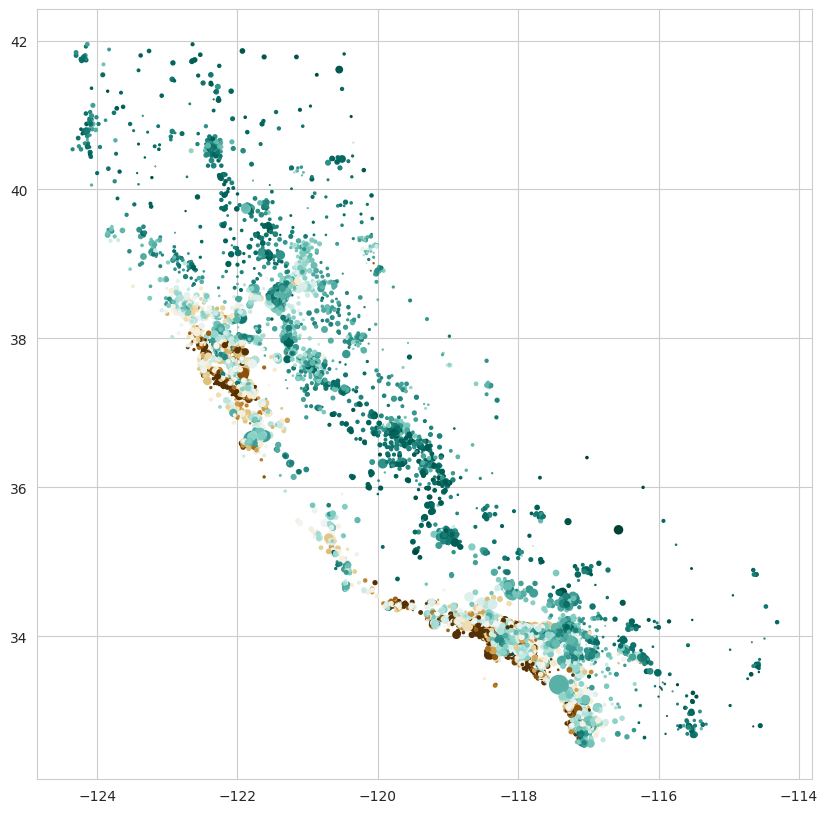

In [5]:
plt.figure(figsize=(10,10))
plt.scatter(X_train['longitude'], X_train['latitude'], s=(X_train['population']/200), c=y_train, cmap='BrBG_r')

In [6]:
y_train[X_train['ocean_proximity']=='<1H OCEAN'].sort_values(ascending=False)

10801    500001.0
8581     500001.0
5244     500001.0
10742    500001.0
8854     500001.0
           ...   
11534     46700.0
11219     45000.0
12217     43000.0
4873      38800.0
2598      36700.0
Name: median_house_value, Length: 6860, dtype: float64

<Axes: xlabel='ocean_proximity', ylabel='median_house_value'>

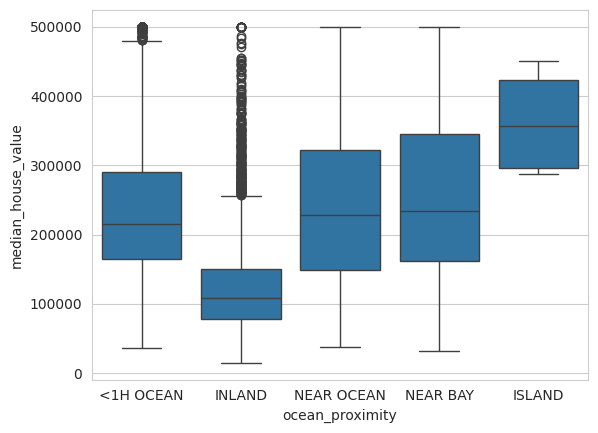

In [7]:
sns.boxplot(data=pd.concat([X_train, y_train], axis=1), x='ocean_proximity', y='median_house_value')

Clearly, `ocean_proximity` is an important feature. Another important feature in housing prices can be distance from major cities. Let's construct that.
This graph highlights major cities.

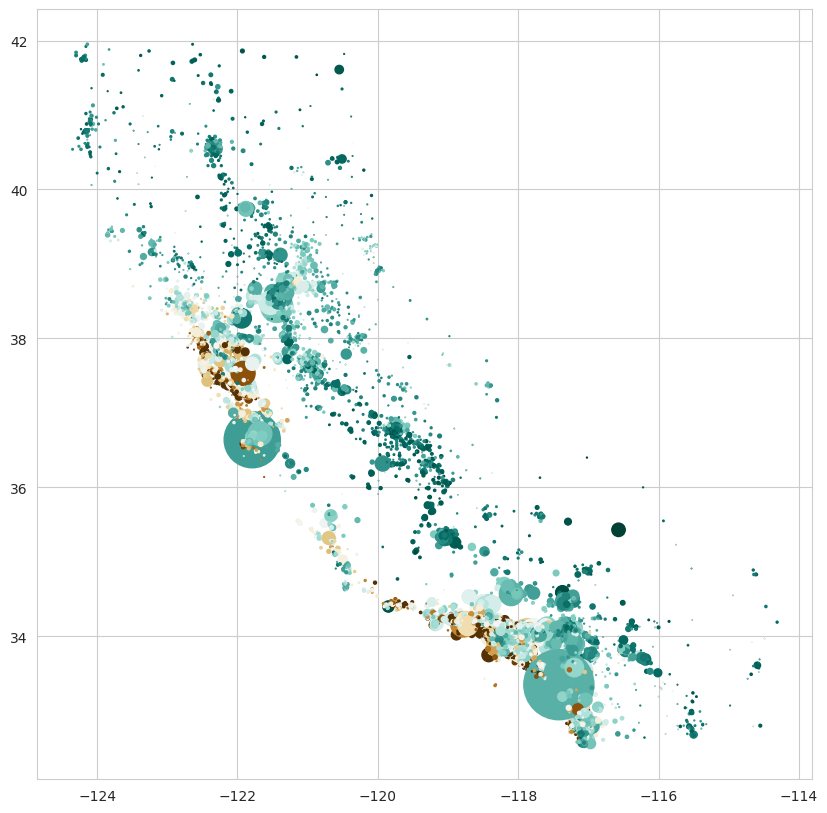

In [8]:
plt.figure(figsize=(10,10))
plt.scatter(X_train['longitude'], X_train['latitude'], s=(X_train['population']**2)/500000, c=y_train, cmap='BrBG_r')

The graph suggests there might be around 10 big circles. In southern California, there seem to many high population centres though. Let us, roughly, consider 20 areas with highest populations to be a major city, and find distances of all data points from these cities in our new feature.

In [9]:
major_cities = X_train[['longitude', 'latitude', 'population']].sort_values(by='population', ascending=False).head(20)
major_cities

,longitude,latitude,population
15360,-117.42,33.35,35682.0
9880,-121.79,36.64,28566.0
13139,-121.44,38.43,16305.0
6057,-117.78,34.03,15507.0
6066,-117.87,34.04,15037.0
12215,-117.12,33.52,13251.0
9019,-118.78,34.16,12873.0
922,-121.92,37.53,12203.0
9744,-121.68,36.72,12153.0
9122,-118.10,34.57,11973.0


In [10]:
def distance(row):
    x1, y1 = row['longitude'], row['latitude']
    dists = []
    for x2, y2 in zip(major_cities['longitude'], major_cities['latitude']):
        cur_dis = np.sqrt((x2-x1)**2+(y2-y1)**2)
        dists.append(cur_dis)
    return min(dists)

distance_from_city = X_train.apply(distance, axis=1)
distance_from_city

8158     0.283019
18368    0.374833
19197    0.771298
3746     0.245153
13073    0.178045
           ...   
11284    0.196977
11964    0.098489
5390     0.357351
860      0.064031
15795    0.554617
Length: 15480, dtype: float64

In [11]:
stats.pearsonr(distance_from_city, y_train)

PearsonRResult(statistic=-0.33264945665196005, pvalue=0.0)

In [12]:
X_train_num = X_train.drop('ocean_proximity', axis=1)
temp_df = pd.concat([X_train_num, y_train, pd.Series(distance_from_city, name='distance_from_city')], axis=1)
temp_df.corr()['median_house_value'].abs().sort_values()

population            0.025960
longitude             0.047271
total_bedrooms        0.048612
households            0.063463
housing_median_age    0.103291
total_rooms           0.133474
latitude              0.142351
distance_from_city    0.332649
median_income         0.688697
median_house_value    1.000000
Name: median_house_value, dtype: float64

Clearly, distance from city is pretty important, in fact, the second most important attribute. Let's look at other features.

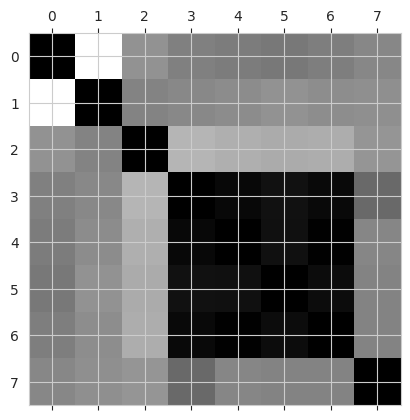

In [13]:
plt.matshow(X_train_num.corr().values, cmap='binary')

Attributes at index 3,4,5 and 6 seem to be very much correlated. We might want to remove some of these or construct new ones out of these which add some information. THe `total_bedrooms` attribute is highly correlated with multiple columns, plus has a low correlation with our target label. Let check if we can get rid of this first.

In [14]:
X_train_num.iloc[:, [3,4,5,6, -2]].corr().median(axis=1)

total_rooms       0.920322
total_bedrooms    0.980270
population        0.907422
households        0.980270
households        0.980270
dtype: float64

In [15]:
def extract_bedrooms(housing_data):
    bedrooms_per_room = housing_data['total_bedrooms']/housing_data['total_rooms']
    return bedrooms_per_room.fillna(bedrooms_per_room.median())

def extract_house_pop(housing_data):
    pop_per_house = housing_data['population']/housing_data['households']
    return pop_per_house.fillna(max(pop_per_house))

bedrooms_per_room = extract_bedrooms(X_train)
pop_per_house = extract_house_pop(X_train)
pop_per_house

8158     2.529412
18368    2.404523
19197    2.235849
3746     2.272549
13073    2.088757
           ...   
11284    3.032258
11964    3.904232
5390     3.332068
860      3.178891
15795    2.108696
Length: 15480, dtype: float64

In [16]:
stats.pearsonr(pop_per_house, y_train)

PearsonRResult(statistic=-0.021421937395641147, pvalue=0.007690157968935672)

In [17]:
stats.pearsonr(bedrooms_per_room, y_train)

PearsonRResult(statistic=-0.2520212805438078, pvalue=7.097385402374278e-223)

`pop_per_household` does not provide any extra information, pretty much similar to the `total bedrooms`; however, `bedrooms_per_room` is considerably better and we should keep it. Let's head straight to cleaning.

In [18]:
len(X_train)-X_train.count()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
ocean_proximity       0
dtype: int64

 Only `total_bedrooms` has missing values. I will now create transformation pipelines for all the steps above for easier automation. The pipeline will consist of the following steps:
 1. A transformer adding engineered features
2. SimpleImputer for missing values, i.e. for `total_bedrooms`
3. OneHotEncoding for `ocean_proximity`
4. StandardScaler for whole dataset
 _____________________________________________________________________________________________________________________________________
 **Transformer for adding features**

In [19]:
class AttribsAdder(base.BaseEstimator, base.TransformerMixin):
    def __init__(self, add_bpr=True, add_distance=True, n_cities=20, remove_bedrooms=False):
        self.feature_names_out_ = None
        self.feature_names_in_ = None
        self.add_bpr = add_bpr
        self.add_distance = add_distance
        self.remove_bedrooms = remove_bedrooms
        self.n_cities = n_cities
        
    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.tolist() if isinstance(X, pd.DataFrame) else None
        return self
    
    def transform(self, X, y=None):
        X_transformed = X.copy()
        if self.add_bpr:
            X_transformed['bedrooms_per_room'] = self.extract_bedrooms(X)
        if self.add_distance:
            major_cities = X_transformed[['longitude', 'latitude', 'population']].sort_values(by='population', ascending=False).head(self.n_cities)
            X['distance_from_city'] = X_transformed.apply(self.distance, cities=major_cities, axis=1)
        if self.remove_bedrooms:
            X.drop('total_bedrooms', axis=1, inplace=True)
        self.feature_names_out_ = X.columns
        return X_transformed.values
    
    def get_feature_names_out(self, X):
        return self.feature_names_out_
    
    @staticmethod
    def distance(row, cities=None):
        x1, y1 = row['longitude'], row['latitude']
        dists = []
        for x2, y2 in zip(cities['longitude'], cities['latitude']):
            cur_dis = np.sqrt((x2-x1)**2+(y2-y1)**2)
            dists.append(cur_dis)
        return min(dists)
    
    @staticmethod
    def extract_bedrooms(housing_data):
        bedrooms_per_room = housing_data['total_bedrooms']/housing_data['total_rooms']
        return bedrooms_per_room.fillna(bedrooms_per_room.median())


In [20]:
num_cols = X_train.columns[:-1].tolist()
cat_cols = [X_train.columns[-1]]
num_cols, cat_cols

(['longitude',
  'latitude',
  'housing_median_age',
  'total_rooms',
  'total_bedrooms',
  'population',
  'households',
  'median_income'],
 ['ocean_proximity'])

In [21]:
num_pipeline = pipeline.Pipeline([('attrib_adder', AttribsAdder()),
                                  ('imputer', impute.SimpleImputer(strategy='median')),
                                  ('scaler', preprocessing.StandardScaler())])

full_transformation_pipeline = compose.ColumnTransformer([('num_pipe', num_pipeline, num_cols),
                                                          ('one_hot', preprocessing.OneHotEncoder(), cat_cols)])

In [22]:
X_train_prep = full_transformation_pipeline.fit_transform(X_train)
X_train_prep

array([[ 0.73099911, -0.8607415 ,  0.66640687, ...,  0.        ,
         0.        ,  0.        ],
       [-1.19670983,  0.70916822,  1.06288858, ...,  0.        ,
         0.        ,  0.        ],
       [-1.55128842,  1.31370062,  0.58711053, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.60115343, -0.75764295,  0.58711053, ...,  0.        ,
         0.        ,  0.        ],
       [-1.1867217 ,  0.90599273, -1.07811266, ...,  0.        ,
         0.        ,  0.        ],
       [-1.41644868,  0.99503238,  1.855852  , ...,  0.        ,
         1.        ,  0.        ]])

In [23]:
full_transformation_pipeline.get_feature_names_out().tolist()

['num_pipe__longitude',
 'num_pipe__latitude',
 'num_pipe__housing_median_age',
 'num_pipe__total_rooms',
 'num_pipe__total_bedrooms',
 'num_pipe__population',
 'num_pipe__households',
 'num_pipe__median_income',
 'num_pipe__distance_from_city',
 'one_hot__ocean_proximity_<1H OCEAN',
 'one_hot__ocean_proximity_INLAND',
 'one_hot__ocean_proximity_ISLAND',
 'one_hot__ocean_proximity_NEAR BAY',
 'one_hot__ocean_proximity_NEAR OCEAN']

In [11]:
joblib.dump(full_transformation_pipeline, 'saved_models/transformation_pipeline.pkl')

['saved_models/transformation_pipeline.pkl']

In [14]:
X_train_new, X_val, y_train_new, y_val = model_selection.train_test_split(X_train_prep, y_train, test_size=0.2)

def errors(model):
    model.fit(X_train_new, y_train_new)
    y_preds_train = model.predict(X_train_new)
    y_preds_val = model.predict(X_val)
    
    print('{0} train error: {1}'.format(model, np.sqrt(metrics.mean_squared_error(y_train_new, y_preds_train))))
    print('{0} val error: {1}'.format(model, np.sqrt(metrics.mean_squared_error(y_val, y_preds_val))))

In [15]:
#rough cell
models = [svm.SVR(), svm.LinearSVR(), svm.SVR(kernel='linear', C=10)]

for model in models:
    errors(model)

SVR() train error: 118666.40013959525
SVR() val error: 117201.94826003537
LinearSVR() train error: 223214.80639508856
LinearSVR() val error: 221568.09372019913


/home/crow/dataspell-projects/my_portfolio/venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


SVR(C=10, kernel='linear') train error: 85128.41748358682
SVR(C=10, kernel='linear') val error: 85571.63361961112


In [17]:
#rough cell
models = [svm.SVR(kernel='rbf', C=10), svm.SVR(kernel='linear', C=50)]

for model in models:
    errors(model)

SVR(C=10) train error: 116200.00330506545
SVR(C=10) val error: 114813.59399223399
SVR(C=50, kernel='linear') train error: 72528.72064969348
SVR(C=50, kernel='linear') val error: 73278.2271959168


In [22]:
#rough cell
models = [svm.SVR(kernel='rbf', C=1000, gamma=0.05), svm.SVR(kernel='linear', C=1000000)]

for model in models:
    errors(model)

SVR(C=1000, gamma=0.05) train error: 70353.44680805733
SVR(C=1000, gamma=0.05) val error: 71552.30652717763
SVR(C=1000000, kernel='linear') train error: 69159.58766294493
SVR(C=1000000, kernel='linear') val error: 69246.24261834321


In [24]:
#rough cell
models = [svm.SVR(kernel='rbf', C=100000, gamma=0.001), svm.SVR(kernel='poly', C=10000, degree=3)]

for model in models:
    errors(model)

SVR(C=100000, gamma=0.001) train error: 69084.69368105342
SVR(C=100000, gamma=0.001) val error: 69712.2414428545
SVR(C=10000, kernel='poly') train error: 72426.00585536574
SVR(C=10000, kernel='poly') val error: 80512.35100639038


In [29]:
params_grid = [{'C':[100000, 1000000], 'gamma':['scale', 0.0005, 0.0001]}]

svm_regress = svm.SVR()
grid = model_selection.GridSearchCV(svm_regress, params_grid, cv=3, n_jobs=-1,error_score='raise', scoring='neg_mean_squared_error')

grid.fit(X_train_prep, y_train)

GridSearchCV(cv=3, error_score='raise', estimator=SVR(), n_jobs=-1,
             param_grid=[{'C': [100000, 1000000],
                          'gamma': ['scale', 0.0005, 0.0001]}],
             scoring='neg_mean_squared_error')

In [35]:
np.sqrt(-grid.cv_results_['mean_test_score'])

array([56914.81345816, 70958.84518217, 79952.53715359, 54716.76872861,
       68380.75894148, 70132.47164816])

In [42]:
models = [svm.SVR(**grid.best_params_, epsilon=0.01), svm.SVR(**grid.best_params_, epsilon=0.001), svm.SVR(**grid.best_params_, epsilon=10)]

for model in models:
    errors(model)

SVR(C=1000000, epsilon=0.01) train error: 50244.17460678013
SVR(C=1000000, epsilon=0.01) val error: 53674.327757259154
SVR(C=1000000, epsilon=0.001) train error: 50244.17511284757
SVR(C=1000000, epsilon=0.001) val error: 53674.32757851548
SVR(C=1000000, epsilon=10) train error: 50243.5848955238
SVR(C=1000000, epsilon=10) val error: 53674.484418159365


{'C': 1000000, 'gamma': 'scale', 'epsilon':0.01} return satisfactory results. Let us train the whole dataset using this model.

In [44]:
final_svm = svm.SVR(kernel='rbf', gamma='scale', C=1000000, epsilon=0.01)
final_svm.fit(X_train_prep, y_train)

SVR(C=1000000, epsilon=0.01)

In [45]:
X_test_prep = full_transformation_pipeline.transform(X_test)
y_preds = final_svm.predict(X_test_prep)

np.sqrt(metrics.mean_squared_error(y_test, y_preds))

54438.44746627292

**Random Forest**

In [35]:
rf = ensemble.RandomForestRegressor(n_estimators=50, max_features=8)

cross_val_scores = model_selection.cross_val_score(rf, X_train_prep, y_train, cv=4, n_jobs=-1, scoring='r2')

In [36]:
cross_val_scores

array([0.81672758, 0.79542351, 0.82403578, 0.80605763])

In [37]:
rf.fit(X_train_prep, y_train)

RandomForestRegressor(max_features=8, n_estimators=50)

In [38]:
X_test_prep = full_transformation_pipeline.transform(X_test)

rf_preds = rf.predict(X_test_prep)
np.sqrt(metrics.mean_squared_error(y_test, rf_preds))

49236.97776747591